# Post Processing of MaxQuant output (proteinGroups.txt)

## Import Data

In [327]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [328]:
datafile="D:\proteinGroupsCleaned.txt"  # From Geremy
#datafile="D:\proteinGroups.txt" # My file
df = pd.read_csv(datafile, sep='\t', lineterminator='\r', dtype={"Only identified by site": str, "Reverse": str})

print(df.head())

     Protein IDs Majority protein IDs Peptide counts (all)  \
0  \n1433B_MOUSE          1433B_MOUSE                   25   
1  \n1433E_MOUSE          1433E_MOUSE                   27   
2  \n1433F_MOUSE          1433F_MOUSE                   28   
3  \n1433G_MOUSE          1433G_MOUSE                   23   
4  \n1433S_MOUSE          1433S_MOUSE                   13   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                            18                      16   
1                            25                      25   
2                            25                      24   
3                            17                      17   
4                            11                      11   

                                       Fasta headers  Number of proteins  \
0  >1433B_MOUSE 14-3-3 protein beta/alpha; AltNam...                 1.0   
1  >1433E_MOUSE 14-3-3 protein epsilon; Short=14-...                 1.0   
2  >1433F_MOUSE 14-3-3 protein eta; Accessio

## Clean Data
* Remove rows corresponding to the proteins only identified by site/Reverse/Potential contaminant
* Remove rows with multiple protein IDs
* Extract separately the LFQ and the iBAQ quantification info


In [329]:
print("Before:", len(df[df['Only identified by site'] == '+']), len(df[df['Reverse'] == '+']), len(df[df['Potential contaminant'] == '+']))

df = df[(df['Only identified by site'] != '+') & (df.Reverse != '+') & (df['Potential contaminant'] != '+')]

print("After:", len(df[df['Only identified by site'] == '+']), len(df[df['Reverse'] == '+']), len(df[df['Potential contaminant'] == '+']))

Before: 13 64 21
After: 0 0 0


In [330]:
### Remove rows with multiple proteinIDs
print("Before:", len(df[df['Majority protein IDs'].str.contains(';', na=False)]))

single_proteinID = df['Majority protein IDs'].str.contains(';')==False
df = df[single_proteinID]

print("After:", len(df[df['Majority protein IDs'].str.contains(';', na=False)]))

Before: 71
After: 0


In [331]:
### Take separate df slices for different quant techniques
LFQ_df = df.filter(regex=("LFQ.*|Majority protein IDs"))
print("***** LFQ_df:\n", LFQ_df.head())

iBAQ_df = df.filter(regex=("iBAQ .*|Majority protein IDs"))
print("\n***** iBAQ_df:\n", iBAQ_df.head())

***** LFQ_df:
   Majority protein IDs  LFQ intensity 04_Liver  LFQ intensity 05_Liver  \
0          1433B_MOUSE            2.093000e+09            1.998200e+09   
1          1433E_MOUSE            3.903200e+09            4.020100e+09   
2          1433F_MOUSE            7.336300e+08            8.709900e+08   
3          1433G_MOUSE            2.660800e+09            2.614600e+09   
4          1433S_MOUSE            0.000000e+00            1.399700e+09   

   LFQ intensity 06_Liver  LFQ intensity 07_Brain  LFQ intensity 07_Heart  \
0            2.184700e+09            1.371400e+10            1.790900e+09   
1            3.902000e+09            1.655000e+10            5.943600e+09   
2            9.208000e+08            9.259900e+09            1.254300e+09   
3            3.038100e+09            2.334300e+10            3.877100e+09   
4            1.961200e+09            7.550100e+09            0.000000e+00   

   LFQ intensity 07_Kidney  LFQ intensity 07_Liver  LFQ intensity 07_Lung  \


## Normalize
### For both LFQ and iBAQ:
* Consider only the proteins observed at least in 50 percent of the sample for at least one organ for quantification
* log2 normalize
* Median normalize: the median of the log2(LFQ or IBAQ) of each protein in a given sample is used to normalize all the protein abundance of this sample, then multiply all the resulting values by the median of the medians
* Impute the missing values: the minimum of the resulting table divided by 2


In [332]:
#########################
#
# TODO: Filter out proteins where quant value is 0 for >= 50% of samples for all organs
#
#########################

num_mice = 6

# Group by organ
iBAQ_cols = iBAQ_df.columns.values.tolist()
organs = ['Liver', 'Kidney', 'Lung', 'Brain', 'Heart']

# Create list of column names corresponding to each organ
for organ in organs:
    regex = re.compile(r'.*' + organ)
    organ_columns = organ.lower() + '_col_names'
    exec("%s=%s" % (organ_columns, list(filter(regex.search, iBAQ_cols))))
    print(organ_columns)
    # Count the number of samples expressing each protein for a given organ
    #organ_count = organ.lower() + 'count'
    #exec("%s=$s" % (organ_count, (iBAQ_df[organ_columns] > 0).sum(1)))
    
print(liver_col_names)
    
liver_cnt = (iBAQ_df[liver_col_names] > 0).sum(1)
lung_cnt = (iBAQ_df[lung_col_names] > 0).sum(1)
print(iBAQ_df[liver_cnt >= num_mice/2])
   
"""
iBAQ_liver_df = iBAQ_df.filter(regex=(".*Liver|Majority protein IDs"))
iBAQ_kidney_df = iBAQ_df.filter(regex=(".*Kidney|Majority protein IDs"))
iBAQ_brain_df = iBAQ_df.filter(regex=(".*Brain|Majority protein IDs"))
iBAQ_heart_df = iBAQ_df.filter(regex=(".*Heart|Majority protein IDs"))
iBAQ_lung_df = iBAQ_df.filter(regex=(".*Lung|Majority protein IDs"))
"""

# Count values > 0, determine if count is at least num_mice/2 for each row:
#print((iBAQ_liver_df[iBAQ_liver_df.columns[1:]] > 0).sum(1) >= num_mice/2)

#liver_observed = iBAQ_liver_df[]
#iBAQ_liver_df = iBAQ_liver_df[liver_observed]


liver_col_names
kidney_col_names
lung_col_names
brain_col_names
heart_col_names
['iBAQ 04_Liver', 'iBAQ 05_Liver', 'iBAQ 06_Liver', 'iBAQ 07_Liver', 'iBAQ 08_Liver', 'iBAQ 09_Liver']
     Majority protein IDs  iBAQ 04_Liver  iBAQ 05_Liver  iBAQ 06_Liver  \
0             1433B_MOUSE   9.804600e+07    108870000.0   1.569600e+08   
1             1433E_MOUSE   2.524900e+08    276160000.0   2.651400e+08   
2             1433F_MOUSE   2.853500e+07     46298000.0   3.592800e+07   
3             1433G_MOUSE   1.788300e+08    183670000.0   1.914300e+08   
4             1433S_MOUSE   5.383400e+07     61420000.0   9.270000e+07   
5             1433T_MOUSE   9.910800e+07     79532000.0   1.206400e+08   
6             1433Z_MOUSE   2.895200e+08    320850000.0   3.960400e+08   
7              2A5A_MOUSE   1.536100e+06      1660500.0   6.764000e+05   
8              2A5E_MOUSE   3.641600e+06      1747700.0   3.368800e+06   
9              2A5G_MOUSE   7.950000e+05      1001800.0   9.401000e+05   
10 

'\niBAQ_liver_df = iBAQ_df.filter(regex=(".*Liver|Majority protein IDs"))\niBAQ_kidney_df = iBAQ_df.filter(regex=(".*Kidney|Majority protein IDs"))\niBAQ_brain_df = iBAQ_df.filter(regex=(".*Brain|Majority protein IDs"))\niBAQ_heart_df = iBAQ_df.filter(regex=(".*Heart|Majority protein IDs"))\niBAQ_lung_df = iBAQ_df.filter(regex=(".*Lung|Majority protein IDs"))\n'

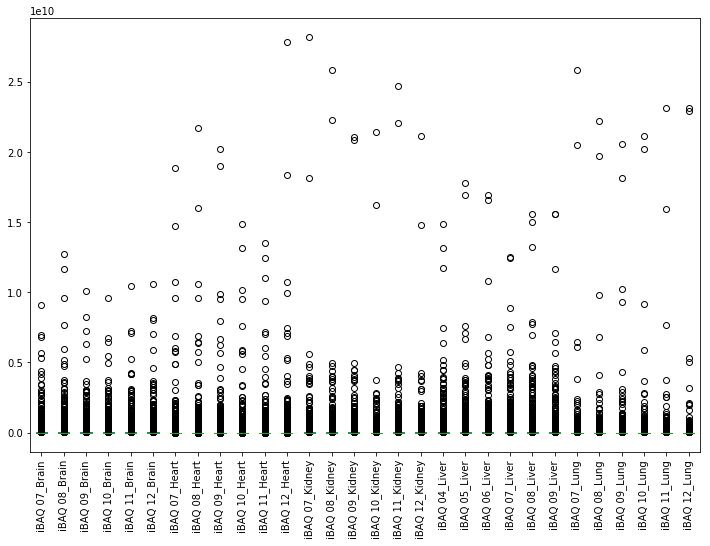

In [333]:
#########################
#
# Unnormalized data abundances 
#
#########################

# Group columns by organ so x-axis will also be grouped
iBAQ_df = iBAQ_df[['Majority protein IDs'] + brain_col_names + heart_col_names + kidney_col_names + liver_col_names + lung_col_names]

iBAQ_df.plot(kind='box', return_type='axes', figsize=(12,8))
plt.xticks(rotation='vertical')
plt.show()

In [334]:
#########################
#
# log2 normalize
#
#########################

iBAQ_df.iloc[:,1:] = iBAQ_df.iloc[:,1:].applymap(np.log2)

print(iBAQ_df.head())

# log2(0) returns -inf; replace with NaN to avoid skewing data
iBAQ_df.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4451: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.asobject, func)


  Majority protein IDs  iBAQ 07_Brain  iBAQ 08_Brain  iBAQ 09_Brain  \
0          1433B_MOUSE      29.897295      29.850685      29.509337   
1          1433E_MOUSE      29.804751      30.438967      29.688125   
2          1433F_MOUSE      29.412036      29.154532      29.276819   
3          1433G_MOUSE      30.647616      30.379375      30.266065   
4          1433S_MOUSE      28.918036      28.992751      28.983974   

   iBAQ 10_Brain  iBAQ 11_Brain  iBAQ 12_Brain  iBAQ 07_Heart  iBAQ 08_Heart  \
0      29.094665      29.821559      29.712026      25.702398      25.617593   
1      29.719928      30.074697      30.296907      27.074799      26.930328   
2      29.065045      29.366822      29.403995      24.583883      24.376236   
3      30.238656      30.261477      30.357938      26.637961      26.518558   
4      28.582441      28.746568      28.906213      25.333199      25.168826   

   iBAQ 09_Heart      ...       iBAQ 06_Liver  iBAQ 07_Liver  iBAQ 08_Liver  \
0      25.876

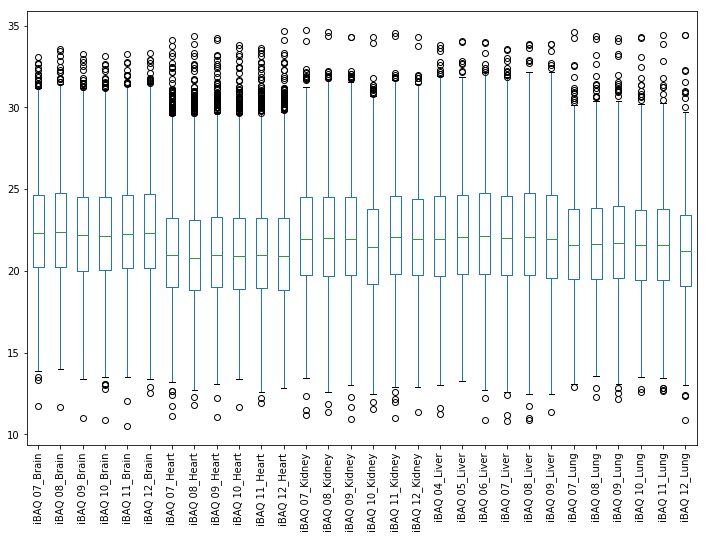

In [335]:
#########################
#
# log2 transformed distribution 
#
#########################

iBAQ_df.plot(kind='box', return_type='axes', figsize=(12,8))
plt.xticks(rotation='vertical')
plt.show()

In [336]:
#########################
#
# Median normalize
#
#########################

iBAQ_quants = iBAQ_df.iloc[:,1:] # Split off iBAQ columns to process
iBAQ_median_of_medians = iBAQ_quants.median().median()

iBAQ_quants /= iBAQ_quants.median(axis=0) # divide each value by sample median
iBAQ_quants *= iBAQ_median_of_medians # multiply each value by median of medians

iBAQ_df.iloc[:,1:] = iBAQ_quants # insert processed iBAQ values into original df
print(iBAQ_df.head())

  Majority protein IDs  iBAQ 07_Brain  iBAQ 08_Brain  iBAQ 09_Brain  \
0          1433B_MOUSE      29.381409      29.228790      29.201553   
1          1433E_MOUSE      29.290462      29.804816      29.378476   
2          1433F_MOUSE      28.904522      28.547141      28.971460   
3          1433G_MOUSE      30.118783      29.746466      29.950389   
4          1433S_MOUSE      28.419047      28.388730      28.681669   

   iBAQ 10_Brain  iBAQ 11_Brain  iBAQ 12_Brain  iBAQ 07_Heart  iBAQ 08_Heart  \
0      28.865142      29.380981      29.235091      26.922035      27.067461   
1      29.485472      29.630378      29.810583      28.359560      28.454493   
2      28.835755      28.932962      28.932005      25.750444      25.755848   
3      30.000108      29.814399      29.870635      27.901993      28.019419   
4      28.356959      28.321871      28.442212      26.535317      26.593296   

   iBAQ 09_Heart      ...       iBAQ 06_Liver  iBAQ 07_Liver  iBAQ 08_Liver  \
0      27.098

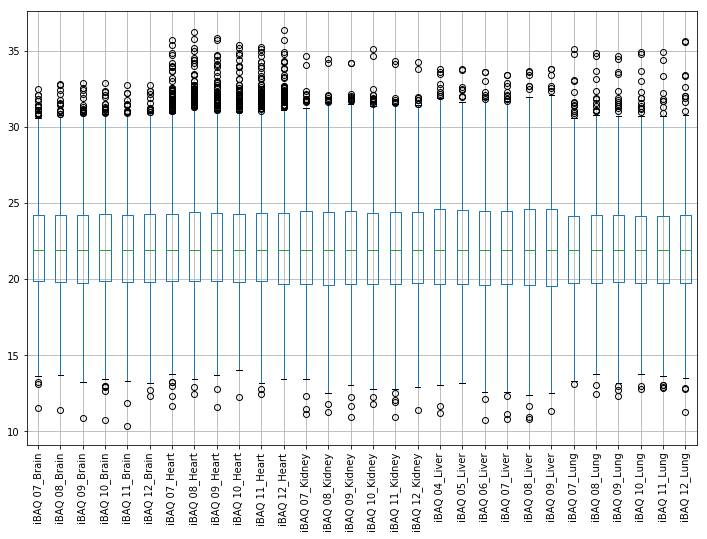

In [337]:
#########################
#
# Median normalized log2 data distribution 
#
#########################

iBAQ_df.boxplot(return_type='axes', figsize=(12,8))
plt.xticks(rotation='vertical')
plt.show()

In [338]:
#########################
#
# Impute missing values
#
#########################

print(iBAQ_df.isnull().values.any()) # Should return true if any nulls are present

iBAQ_min = iBAQ_quants.min().min()
iBAQ_impute_val = iBAQ_min/2

iBAQ_df = iBAQ_df.fillna(iBAQ_impute_val)

print(iBAQ_df.isnull().values.any()) # Should return false if nulls have been replaced

True
False


## PCA

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


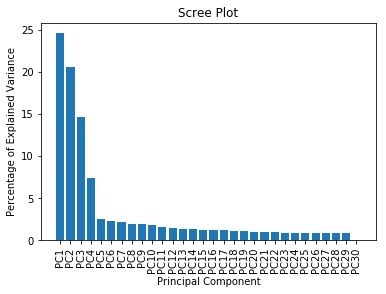

In [339]:
#########################
#
# Perform PCA on the data
#
#########################

scaled_data = preprocessing.scale(iBAQ_df.iloc[:, 1:].T)
#scaled_data = iBAQ_df.iloc[:, 1:]
    
pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
#pca.fit(iBAQ_df) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe
 
#########################
#
# Draw a scree plot 
#
#########################
 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.xticks(rotation='vertical')
plt.show()


In [340]:
pca_df = pd.DataFrame(pca_data, index=[iBAQ_df.columns.values()], columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()

TypeError: 'numpy.ndarray' object is not callable

## ANOVA and t-tests

In [ ]:
# Extract individual groups

# Perform ANOVA

## Generate Images
* Hierarchical clustering
* Heatmap
* PCA
* Pearson Correlation

In [ ]:
### Testing import of python file

import test_func as tf

tf.my_func("Hakuna Matata")